In [1]:
import distiller 
import numpy as np
import os, collections
import bitstring 
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision 
import models 
from matplotlib import pyplot as plt
from eval_util import test_imagenet 
# import multiprocessing 
%matplotlib inline

from fault_injection import * 

import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42

# print('using GPU:', torch.cuda.is_available())
# torch.manual_seed(1)

/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# check the weight distribution of other pre-trained models in torch vision
# use resnet18, alexnet, vgg16 

pretrained_models = {'resnet18': torchvision.models.resnet18(pretrained=True),
                     'resnet34': torchvision.models.resnet34(pretrained=True),
                     'alexnet': torchvision.models.alexnet(pretrained=True),
                     'squeezenet': torchvision.models.squeezenet1_0(pretrained=True),
                     'vgg16':  torchvision.models.vgg16(pretrained=True), 
                      'vgg16_bn':  torchvision.models.vgg16_bn(pretrained=True), 
#                      'densenet':  torchvision.models.densenet161(pretrained=True),
                     'inception_v3':  torchvision.models.inception_v3(pretrained=True),
                    }

# model_name = 'vgg16'
# model_name = 'resnet18'
model_name = 'squeezenet'
model = pretrained_models[model_name]
# print(model)

/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/hguan2/anaconda2/envs/distiller/lib/python3.5/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [3]:
# check model weight size is a multiple of eight
for name, param in model.named_parameters():
    if len(param.size()) < 2:
        continue 
    length = param.nelement()
    assert length%8 == 0, '#values not equal to 8X: %d' %(length)
#     print(name, param.size(), '8X?', length%8 == 0)
    


In [4]:
# post train quantization 
quantizer = distiller.quantization.PostTrainLinearQuantizer(model)
quantizer.prepare_model()
# print(model)


In [5]:
# import collections 
def get_named_weights(model):
    named_params = [] 
    for name, param in model.named_parameters():
        if len(param.size()) >= 2:
            named_params.append((name, param)) 
    return named_params 

def large_value_stats(tensor, thr=64, BCH=False, debug=False):
    '''tensor is a torch tensor, thr is the large value threshold
    inputs:
    1. tensor: torch tensor, will be flatten to 1-d tensor
    2. thr: large value threshold, can only be 32 or 64 
    3. BCH: whether BCH double error correction code is used. BCH has 12 bits to encode indexes/tile size. 
    4. debug: in debug mode, print out intermediate results. 
    
    return stats includes:
    1. #large values,
    2. percentage of large values 
    3. absolute storage overhead of their indexes (overhead is in #header; each header is 64 bits)'''
    tensor = tensor.view(-1)
    size = tensor.nelement()
    indexes = torch.nonzero((tensor > thr-1) + (tensor < -thr)).view(-1) # 1-d tensor 
    num_large_values = indexes.size()[0]
    percentage = round(num_large_values * 1.0 / size, 6)
    
    if debug:
        print('large value indexes:', indexes)
    
    # get the overhead of storing the indexes
    # a header of 64 bits, first 2Bytes indicating tile size, the following 6bytes can record maximum 3 indexes 
    # three constaints: 
    # 1) ECC encoding applied to header, thus, the maximum number of bits for representing tile size in bytes is 
    # 
    # 2) tile size = min{ maximum tile size, length of a tile that has maximum of 3 large values}
    # 3) tile size is a multiple of segment size 
    encoding_format = (thr, BCH)
    encoding_format_to_max_tile_size = {(64, False): 2**14, (32, True): 2**12, (32, False): 2**11}
    assert encoding_format in encoding_format_to_max_tile_size, 'encoding format not valid:%s' %(str(encoding_format))
    segment_size = 8 # number of weights/bytes in a segment for data loading, 64 bit  
    num_segments = size // 8 
    segment_indexes = indexes//segment_size # segment indexes of large values 
    counter = sorted(collections.Counter(segment_indexes).items(), reverse=True) # a stack, use pop 
    if debug:
        print('#weights:', size )
        print('#segments:', num_segments)
        print('large value segments:', sorted([(x.item(), y) for x,y in counter]))
    
    overhead = 0
    tile_start_id = 0 # start segment id in the tile 
#     max_tile_size = 2**12//segment_size if thr == 32 else 2**14//segment_size # in the unit of segment 
    max_tile_size = encoding_format_to_max_tile_size[encoding_format]//segment_size # in the unit of segment 
    
    while tile_start_id < num_segments:
        tile_end_id = min(tile_start_id + max_tile_size, num_segments)-1
        # a large value can be included in the tile if it meets all the following conditions
        # 1) it is the first three large values 
        # 2) its segment_id is no larger than tile_max_end_id 
        # 3) if it is the third one, its following neighbors cannot lie in the same segment. 
        
        budget = 3 
        while counter and counter[-1][0] <= tile_end_id and budget - counter[-1][-1] >= 0:
            item = counter.pop()
            budget -= item[-1]
        # if three indexes are found, make sure the tile size doesn't cover the third one if exist
        # otherwise, can use the max end id 
        if not budget and counter:
            tile_end_id = min(tile_end_id, counter[-1][0]-1)
        if debug:
            print('tile_start_id:%d, end_id:%d' %(tile_start_id, tile_end_id))
        tile_start_id = tile_end_id + 1 
        overhead += 1
  
    return thr, size, num_large_values, percentage, overhead 


def test_large_value_stats():
    tensor = torch.randint(-70, 75, size=(100, ))
    print(tensor)
    print(large_value_stats(tensor, thr=64, debug=True))
    
# test_large_value_stats() 


# named_params = get_named_weights(model)
# for thr, BCH in [(64, False), (32, True), (32, False)]:
#     print('encoding format:', str((thr, BCH)))
#     n_larges = [] 
#     weight_id = 0 
#     for name, param in named_params:
#         tensor = param.data 
#         n_larges.append((weight_id, name, large_value_stats(tensor, thr=thr, BCH=BCH))) # 1-bit correction, ECC
#         weight_id += 1

#     # sort based on the storage overhead 
#     sorted_n_larges = sorted(n_larges, key = lambda x: x[2][-1], reverse = True)
#     for item in sorted_n_larges:
#         print(item)


In [6]:
# maximize protection
# s.t. storage budget constraint 
# get all the possible budgets
def check_directory(path):
    if not os.path.isdir(path):
        os.makedirs(path)

dataset = 'imagenet'
data_type = 'int8'
folder_name = 'gradual_encoding_adaptive'
named_params = get_named_weights(model)

model_bytes = sum([param.nelement() for name, param in named_params])
header_bytes = 8
    
# write the encoding order to the following folder
log_path = os.path.join('./logs/', model_name, dataset, data_type, folder_name)
check_directory(log_path)

def first_tier(named_params):
    # init 
    budgets = [0]
    overheads = [0] 
    
    layer_overheads = [0]*len(named_params) # default lossy overhead is zero for every layer 

    # tier-1 
    filename = 'tier1.txt'
    thr, BCH = 64, False
    
    print('first tier with encoding config (thr, BCH):', str((thr, BCH)))
    n_larges = [] 
    weight_id = 0 
    for name, param in named_params:
        tensor = param.data 
        n_larges.append((weight_id, name, large_value_stats(tensor, thr=thr, BCH=BCH))) # 1-bit correction, ECC
        weight_id += 1
    
    # sort n_larges in increasing order of overhead
    sorted_n_larges = sorted(n_larges, key = lambda x: x[2][-1])
    for item in sorted_n_larges:
        weight_id = item[0]
        layer_overhead = item[2][-1]
        # update 
        layer_overheads[weight_id] = layer_overhead 
        overheads.append(overheads[-1] + layer_overhead)
        budgets.append(overheads[-1]* header_bytes * 100/ model_bytes)

    # write sorted_n_larges
    with open(os.path.join(log_path, filename), 'w') as f:
        for item, overhead, budget in zip(sorted_n_larges, overheads[1:], budgets[1:]):
            f.write('%d, %s, %s, %d, %.6f\n' %(item[0], item[1], item[2], overhead, budget))
    
    return budgets, overheads, layer_overheads 

def second_tier(named_params,  budgets, overheads, layer_overheads, encoding_format='BCH'):
    # deep copy 
    budgets = [x for x in budgets]
    overheads = [x for x in overheads]
    layer_overheads = [x for x in layer_overheads]
    
    # tier-2 with BCH
    filename = 'tier2_' + encoding_format + '.txt'
    thr, BCH = 32, True
    if encoding_format == 'ECC':
        BCH = False 
        
    print('second tier with encoding config (thr, BCH):', str((thr, BCH)))
    n_larges = [] 
    weight_id = 0 
    for name, param in named_params:
        tensor = param.data 
        n_larges.append((weight_id, name, large_value_stats(tensor, thr=thr, BCH=BCH))) 
        weight_id += 1
    
    # sort n_larges in increasing order of overhead
    sorted_n_larges = sorted(n_larges, key = lambda x: x[2][-1])
    for item in sorted_n_larges:
        weight_id = item[0]
        layer_overhead = item[2][-1]
        # update 
        layer_overheads[weight_id] = layer_overhead 
        overheads.append(sum(layer_overheads))
        budgets.append(overheads[-1] * header_bytes * 100 / model_bytes)

    # write sorted_n_larges
    N = len(named_params)
    with open(os.path.join(log_path, filename), 'w') as f:
        for item, overhead, budget in zip(sorted_n_larges, overheads[1+N:], budgets[1+N:]):
            f.write('%d, %s, %s, %d, %.6f\n' %(item[0], item[1], item[2], overhead, budget))   
    return budgets, overheads, layer_overheads 

tier1_budgets, tier1_overheads, tier1_layer_overheads = first_tier(named_params)
BCH_budgets, BCH_overheads, BCH_layer_overheads = second_tier(named_params, 
                                                  tier1_budgets, 
                                                  tier1_overheads, 
                                                  tier1_layer_overheads, 'BCH')
ECC_budgets, ECC_overheads, ECC_layer_overheads = second_tier(named_params, 
                                                  tier1_budgets, 
                                                  tier1_overheads, 
                                                  tier1_layer_overheads, 'ECC')


first tier with encoding config (thr, BCH): (64, False)
second tier with encoding config (thr, BCH): (32, True)
second tier with encoding config (thr, BCH): (32, False)


BCH_budgets: 0:0.000000, 1:0.000643, 2:0.002571, 3:0.007071, 4:0.012214, 5:0.017357, 6:0.023143, 7:0.029571, 8:0.036000, 9:0.043071, 10:0.050786, 11:0.058500, 12:0.066857, 13:0.075857, 14:0.086143, 15:0.097071, 16:0.109928, 17:0.122785, 18:0.137571, 19:0.153000, 20:0.169714, 21:0.192857, 22:0.217928, 23:0.243642, 24:0.269999, 25:0.326570, 26:0.602355, 27:0.608784, 28:0.635141, 29:0.665355, 30:0.701355, 31:0.732855, 32:0.780426, 33:0.833783, 34:0.890997, 35:0.944997, 36:1.007997, 37:1.079997, 38:1.156497, 39:1.251639, 40:1.360282, 41:1.483710, 42:1.623210, 43:1.758209, 44:1.911209, 45:2.068066, 46:2.228779, 47:2.447350, 48:2.653707, 49:2.914063, 50:3.252848, 51:3.994060, 52:12.450179
ECC_budgets: 0:0.000000, 1:0.000643, 2:0.002571, 3:0.007071, 4:0.012214, 5:0.017357, 6:0.023143, 7:0.029571, 8:0.036000, 9:0.043071, 10:0.050786, 11:0.058500, 12:0.066857, 13:0.075857, 14:0.086143, 15:0.097071, 16:0.109928, 17:0.122785, 18:0.137571, 19:0.153000, 20:0.169714, 21:0.192857, 22:0.217928, 23:0.2

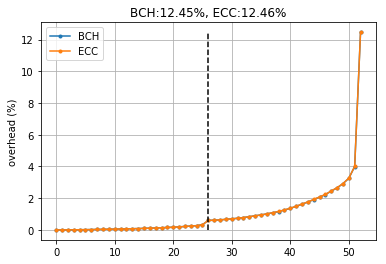

In [7]:
# turn budgets from the unit of #header to percentage 
plt.plot(BCH_budgets, marker='.', label='BCH')
print('BCH_budgets:', ', '.join(['%d:%.6f' %(i, x) for i, x in enumerate(BCH_budgets)]))
plt.plot(ECC_budgets, marker='.', label='ECC')
print('ECC_budgets:', ', '.join(['%d:%.6f' %(i, x) for i, x in enumerate(ECC_budgets)]))
plt.ylabel('overhead (%)')
plt.title('BCH:%.2f%%, ECC:%.2f%%' %(BCH_budgets[-1], ECC_budgets[-1]))
plt.plot([len(named_params)]*2, [0, ECC_budgets[-1]], '--k')
plt.grid()
plt.legend()
plt.show()

In [15]:
# fault injection to model with certain protection 
# load the sorted weight ids
import json
def load_sorted_weight_ids(filename):
    sorted_weight_ids = [] 
    with open(os.path.join(log_path, filename), 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line:
                items = line.split(',')
                weight_id = int(items[0])
                budget = float(items[-1]) # accumulated budget 
                sorted_weight_ids.append((weight_id, budget))
    return sorted_weight_ids 



step_size_dict = {'resnet18': 0.5,
                 'vgg16': 1,
                 'squeezenet': 2}
step_size = step_size_dict[model_name]
    

def tier1_candidate_budgets(step_size, encoding_format='ECC64'):
    assert encoding_format == 'ECC64', 'only support encoding format ECC64'
    # init 
    budget_configs = []
    config_id = 0
    target_budget = step_size
    pre_budget = 0 
    filename = 'tier1.txt'
    sorted_weight_ids = load_sorted_weight_ids(filename)

    # first two config are special cases
    config = {'ECC64': [], 
             'budget': 0,
             'target_budget': 0, 
             'config_id': config_id}
    budget_configs.append(config)
    config_id += 1

    config = {'ECC64': [x[0] for x in sorted_weight_ids], 
             'budget': round(sorted_weight_ids[-1][-1], 6), 
             'target_budget': round(sorted_weight_ids[-1][-1], 6), 
             'config_id': config_id}
    budget_configs.append(config)
    config_id += 1

    
    for i, item in enumerate(sorted_weight_ids):
        # if the current_budget > target_budget ==> set config 
        weight_id, cur_budget = item

        if cur_budget > target_budget:
            config = {encoding_format: [x[0] for x in sorted_weight_ids[:i]], 
                     'budget': pre_budget,
                     'target_budget': target_budget,
                     'config_id': config_id}
            budget_configs.append(config)
            config_id += 1

            # increase target_budget
            target_budget += step_size 
        pre_budget = cur_budget 
    filepath = os.path.join(log_path, 'tier1_budgets.json')
    if not os.path.isfile(filepath):
        with open(filepath, 'w') as f:
            json.dump(budget_configs, f)
    return budget_configs 

def tier2_candidate_budgets(step_size, encoding_format='BCH'):
    assert encoding_format in ['BCH', 'ECC'], 'only support encoding format: BCH and ECC'
    # init 
    budget_configs = []
    config_id = 0
    target_budget = step_size
    pre_budget = 0 
    filename = 'tier2_'+ encoding_format +'.txt'
    sorted_weight_ids = load_sorted_weight_ids(filename)

    # first one config are special cases
    config = {encoding_format: [x[0] for x in sorted_weight_ids], 
             'budget': round(sorted_weight_ids[-1][-1], 6), 
             'target_budget': round(sorted_weight_ids[-1][-1], 6), 
             'config_id': config_id}
    config_id += 1
    budget_configs.append(config)

    
    for i, item in enumerate(sorted_weight_ids):
        # if the current_budget > target_budget ==> set config 
        weight_id, cur_budget = item

        if cur_budget > target_budget:
            config = {encoding_format: [x[0] for x in sorted_weight_ids[:i]], 
                     'budget': pre_budget,
                     'target_budget': target_budget,
                     'config_id': config_id}
            budget_configs.append(config)
            config_id += 1

            # increase target_budget
            target_budget += step_size 
        pre_budget = cur_budget 
    
    filepath = os.path.join(log_path, 'tier2_' + encoding_format + '_budgets.json')
    if not os.path.isfile(filepath):
        with open(filepath, 'w') as f:
            json.dump(budget_configs, f)
    return budget_configs 

tier1_configs = tier1_candidate_budgets(step_size)
tier2_BCH_configs = tier2_candidate_budgets(step_size, encoding_format='BCH')
tier2_ECC_configs = tier2_candidate_budgets(step_size, encoding_format='ECC')
print('\ntier1')
for config in tier1_configs:
    print(config)
print('\ntier2_BCH')
for config in tier2_BCH_configs:
    print(config)
print('\ntier2_ECC')
for config in tier2_ECC_configs:
    print(config)
 



tier1
{'config_id': 0, 'budget': 0, 'target_budget': 0, 'ECC64': []}
{'config_id': 1, 'budget': 0.602355, 'target_budget': 0.602355, 'ECC64': [10, 9, 5, 3, 15, 21, 7, 12, 8, 14, 24, 17, 18, 1, 2, 16, 22, 4, 19, 11, 20, 6, 0, 13, 23, 25]}

tier2_BCH
{'config_id': 0, 'budget': 12.450179, 'BCH': [10, 5, 1, 3, 2, 7, 9, 8, 4, 21, 12, 14, 15, 11, 16, 17, 6, 24, 13, 0, 18, 20, 19, 22, 23, 25], 'target_budget': 12.450179}
{'config_id': 1, 'budget': 1.911209, 'BCH': [10, 5, 1, 3, 2, 7, 9, 8, 4, 21, 12, 14, 15, 11, 16, 17, 6, 24], 'target_budget': 2}
{'config_id': 2, 'budget': 3.99406, 'BCH': [10, 5, 1, 3, 2, 7, 9, 8, 4, 21, 12, 14, 15, 11, 16, 17, 6, 24, 13, 0, 18, 20, 19, 22, 23], 'target_budget': 4}

tier2_ECC
{'config_id': 0, 'ECC': [10, 5, 1, 3, 2, 7, 9, 8, 4, 21, 12, 14, 15, 11, 16, 17, 6, 24, 13, 0, 18, 20, 19, 22, 23, 25], 'target_budget': 12.459179, 'budget': 12.459179}
{'config_id': 1, 'ECC': [10, 5, 1, 3, 2, 7, 9, 8, 4, 21, 12, 14, 15, 11, 16, 17, 6, 24], 'target_budget': 2, 'budget'

In [9]:
# def large_value_max_distance(tensor):
#     '''tensor has to be 1-d tensor'''
#     size = tensor.nelement()
#     tensor = tensor.view(-1)
#     indexes = torch.nonzero((tensor > 63) + (tensor < -64)).view(-1)
#     diff = indexes[1:] - indexes[:-1]
#     d = torch.max(diff)
#     return d.item() 

# # print the maximum distance between large values 
# weight_id = 0 
# for name, param in named_params:
#     print(weight_id, name, large_value_max_distance(param.data))
#     weight_id += 1



In [10]:
# check the distribution of parameters 
# thr = 32
# layer_id = 0 
# for param_name, param in model.named_parameters():
#     if len(param.size()) < 2:
#         continue
#     counter = collections.Counter(np.abs(param.data.cpu().numpy().ravel())//thr)
#     tmp = sorted(counter.items(), key=lambda x: x[0])
#     values, counts = zip(*tmp)
#     percentages = [count/sum(list(counts)) for count in counts]
#     bar = plt.bar(values, percentages)
#     for rect in bar:
#         height = rect.get_height()
#         plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f%%' %(height*100), ha='center', va='bottom')
# #     print(['%.2f' %(p) for p in percentages])
#     #plt.hist(param.data.cpu().numpy().ravel(), bins=10, density=True)
#     plt.xticks(values, [str(int(v)*thr+thr) for v in values])
#     plt.title('layer_id:'+str(layer_id) + ', '+ str(tuple(param.size())))
# #     plt.grid()
#     plt.ylim(0, 1.1)
#     plt.show()
#     layer_id += 1

In [11]:
# check the distribution of parameters all weights
# thr = 32
# total_values, num_weights = 0, 0 
# counter = collections.Counter()
# for param_name, param in model.named_parameters():
#     total_values += param.nelement()
#     if len(param.size()) < 2:
#         continue
#     num_weights += param.nelement()
#     counter.update(collections.Counter(np.abs(param.data.cpu().numpy().ravel())//thr + 1))
    
# tmp = sorted(counter.items(), key=lambda x: x[0])
# values, counts = zip(*tmp)
# total_weights = sum(list(counts))

# assert total_weights == num_weights
# print('#weights:', total_weights, ', #params:', total_values, 'percentage:', '%.6f' %(num_weights/total_values))

# percentages = [count/total_weights for count in counts]
# bar = plt.bar(values, percentages)
# for rect in bar:
#     height = rect.get_height()
#     plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.4f%%' %(height*100), ha='center', va='bottom')
# #     print(['%.2f' %(p) for p in percentages])
# #plt.hist(param.data.cpu().numpy().ravel(), bins=10, density=True)
# # plt.xticks(values, [str(int(v)*thr) for v in values])
# plt.xticks(values, ['[0, 32]', '[32, 64]', '[64, 96]', '[96, 128]'])
# plt.title(model_name)
# #     plt.grid()
# plt.ylim(0, 1.1)
# plt.show()

# figdir = './figures/weight_distribution/'
# figname = model_name+'_int8_weight_distribution.pdf'
# plt.savefig(os.path.join(figdir, figname), bbox_inches='tight')


In [12]:
## load gradual_encoding_absolute result 
# lossy_encoding_results = {
#     'vgg16': './logs/vgg16/imagenet/int8/gradual_encoding_absolute',
#     'resnet18': './logs/resnet18/imagenet/int8/gradual_encoding_absolute',
#     'squeezenet': './logs/squeezenet/imagenet/int8/gradual_encoding_absolute',
# }


# def parse_gradual_encoding_absolute_log(log_path):
#     res = [] 
#     with open(os.path.join(log_path, 'logs.txt'), 'r') as f:
#         lines = f.readlines()
#         for line in lines:
#             line = line.strip()
#             if line:
#                 items = line.split(',')
#                 for item in items:
#                     if 'n_large' in item:
#                         n_large = int(item.split(':')[-1])
#                     if 'name' in item:
#                         name = item.split(':')[-1].strip()
#                     if 'accuracy' in item:
#                         accuracy = float(item.split(':')[-1])
#                 res.append((accuracy, name, n_large))
                
#     return res 

   

# log_path = lossy_encoding_results[model_name]
# res = parse_gradual_encoding_absolute_log(log_path)

# accuracies = [] 
# for a, b in zip(sorted_n_larges, res):
#     weight_id = a[0]
#     accuracy = b[0]
#     name = a[1]
#     n_large = a[2]
#     assert a[1] == b[1], 'param name not equal: %s, %s' %(a[1], b[1])
#     assert a[2] == b[2], 'param n_large not equal: %d, %d' %(a[2], b[2])
#     accuracies.append((weight_id, name, n_large, accuracy))
# for item in accuracies:
#     print(item)
            
            


In [13]:
# # from right to the left, find the k for sorted_layers[:k].
# fault_free_accuracies = {
    
#     'vgg16': 79.36,
#     'resnet18': 76.46,
#     'squeezenet': 66.86,
# }
# max_acc = fault_free_accuracies[model_name]
# min_acc = 0
# accuracy_to_ids = [] 
# for i in range(len(accuracies)-1, -1, -1):
#     accuracy = accuracies[i][-1]
#     if accuracy > min_acc:
#         accuracy_to_ids.append((accuracy, [x[0] for x in accuracies[:i+1]]))
#         min_acc = accuracy 

# # add the option of all weights are lossless 
# accuracy_to_ids.append((0, []))
    
# for item in accuracy_to_ids:
#     print(item)

# # with open(os.path.join(log_path, 'steps.txt'), 'w') as f:
# #     for item in accuracy_to_ids:
# #         s = "%.2f" %(item[0]) + ': '+ ', '.join([str(x) for x in item[1]]) + '\n'
# #         f.write(s) 
    